In [ ]:
#ConvLSTM-SED   multivariable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.python.keras.layers import ConvLSTM2D
from tensorflow.python.keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#matplotlib inline
import time
# fix random seed for reproducibility
np.random.seed(7)

start = time.time()


# load the dataset
#dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/PD-TVFEMD-IMF1.csv', usecols=[6], engine='python')
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD_NFP.csv', engine='python')
#print(dataframe)
print("数据集的长度：",len(dataframe))
dataset = dataframe.values
# 将整型变为float
dataset = dataset.astype('float32')
#print(dataset)

timestep = 6
dim = 6
#数据缩放 拆分输入X（7维）&输出Y（1维）
X = dataset[:,0:6]
scaler = MinMaxScaler(feature_range=(0, 1))
for i in range(dim):
    Xdata = X[:,i]
    Xdata = Xdata.reshape(-1,1)
    Xdata = scaler.fit_transform(Xdata)
    Xdata = Xdata.flatten()
    X[:,i] = Xdata
X_scaler = X.reshape(324,-1)

Y = dataset[:,0]
Y_scaler= (Y-np.min(Y))/(np.max(Y)-np.min(Y))
Y_scaler = Y_scaler.reshape(-1)

#print(X_scaler)
#print(Y_scaler)
#print(Y)


# 将数据拆分成训练和测试，8/9作为训练数据
train_size = int(len(dataset) * 0.78)
test_size = len(dataset) - train_size
trainX, testX = X_scaler[0:train_size,:], X_scaler[train_size:len(dataset),:]
trainY, testY = Y_scaler[0:train_size], Y_scaler[train_size:len(dataset)]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)
#print(trainX)
#print(trainY)
#print(testX)
#print(testY)



#重构数据集
##timestep为时间步长
def create_trainX(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[i:(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)

def create_trainY(seq, timestep):
    dataY = []
    for i in range(len(seq)-timestep):
        # Y向后移动一位取值
        dataY.append(seq[i + timestep])
    return np.array(dataY)

def create_testX(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[(i):(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)



#----------forecasting-----------

pres=[]
trainX = create_trainX(trainX, timestep)
trainY = create_trainY(trainY, timestep)
testX = create_testX(testX, timestep) 
testY = testY[timestep:len(testY)]
print("转为监督学习，训练集数据长度：", len(trainX))
#print(trainX,trainY)
print("转为监督学习，测试集数据长度：",len(testX))
#print(testX, testY )


# 数据重构为5D [samples, timesteps, rows, columns, features]
trainX_input5D = np.reshape(trainX, (trainX.shape[0], 2,1,timestep//2, dim))
testX_input5D = np.reshape(testX, (testX.shape[0],2,1,timestep//2, dim))
#trainX_input5D = np.reshape(trainX, (trainX.shape[0], timestep,1,1, dim))
#testX_input5D = np.reshape(testX, (testX.shape[0],timestep,1,1, dim))
print('构造得到模型的输入数据(训练数据已有标签trainY): ',trainX_input5D.shape,testX_input5D.shape)


# create and fit the convlstm network
if __name__ == '__main__':
    model = Sequential()
    model.add(ConvLSTM2D(filters=48, kernel_size=(2,2), activation='relu', 
                         input_shape=(2,1,timestep//2, dim),
#                         input_shape=(timestep,1,1, dim),
                         padding='same', return_sequences=True))
    model.add(ConvLSTM2D(filters=24, kernel_size=(2,2), activation='relu',
                         padding='same', return_sequences=True))

    model.add(Flatten())
    model.add(Dense(1))

    model.compile(loss='mse', optimizer='adam')
    model.fit(trainX_input5D, trainY, epochs=1000)

    # 打印模型
    model.summary()

    # 开始预测
    trainPredict = model.predict(trainX_input5D)
    testPredict = model.predict(testX_input5D)

    # 逆缩放预测值
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD_NFP.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    #trainPredict = trainPredict*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori = trainY*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori=trainY_re.reshape((246,1))
    testPredict = testPredict*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPredict.reshape(-1)
    Y = dataset[:,0]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape(-1)

    

    # 计算误差
    #trainScore = math.sqrt(mean_squared_error(trainY_ori[:,0], trainPredict[:,0]))
    #print('Train Score: %.2f RMSE' % (trainScore))
    #testScore = math.sqrt(mean_squared_error(testY_ori[:,0], testPredict[:,0]))
    #print('Test Score: %.2f RMSE' % (testScore))


    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPre[i])
        error1.append(abs((testY_ori[i] - testPre[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPre[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPre[i]*testPre[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPre[i+1])/testY_ori[i])*((testY_ori[i+1] - testPre[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPre[i])/testY_ori[i])*((testY_ori[i+1] - testPre[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPre=testPre.reshape(-1)
    testPre=pd.DataFrame(testPre)
    testPre.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/convlstmoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/convlstmEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)
    
    plt.figure(facecolor='white')
    plt.plot(testPre,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPre)



end = time.time()
print('Running time: %d seconds'%(end - start))

In [ ]:
#TSRConvLSTM-SED-(2,3)
import numpy
import pandas
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.python.keras.layers import ConvLSTM2D
from tensorflow.python.keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#matplotlib inline
import time
# fix random seed for reproducibility
numpy.random.seed(7)

start = time.time()

# load the dataset
#dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/PD-IMF1.csv', usecols=[6], engine='python')
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD_NFP.csv', engine='python')
#print(dataframe)
print("数据集的长度：",len(dataframe))
dataset = dataframe.values
# 将整型变为float
dataset = dataset.astype('float32')
#print(dataset)
X11 = dataset[:,0]#Y
X11_scaler= (X11-numpy.min(X11))/(numpy.max(X11)-numpy.min(X11))
X11_scaler = X11_scaler.reshape(-1)

X12 = dataset[:,1]
X12_scaler= (X12-numpy.min(X12))/(numpy.max(X12)-numpy.min(X12))
X12_scaler = X12_scaler.reshape(-1)

X13 = dataset[:,2]
X13_scaler= (X13-numpy.min(X13))/(numpy.max(X13)-numpy.min(X13))
X13_scaler = X13_scaler.reshape(-1)

X21 = dataset[:,3]
X21_scaler= (X21-numpy.min(X21))/(numpy.max(X21)-numpy.min(X21))
X21_scaler = X21_scaler.reshape(-1)

X22 = dataset[:,4]
X22_scaler= (X22-numpy.min(X22))/(numpy.max(X22)-numpy.min(X22))
X22_scaler = X22_scaler.reshape(-1)

X23 = dataset[:,5]
X23_scaler= (X23-numpy.min(X23))/(numpy.max(X23)-numpy.min(X23))
X23_scaler = X23_scaler.reshape(-1)



XX = numpy.zeros([324,2,3])
XX[:,0,0] = X11_scaler
XX[:,0,1] = X12_scaler
XX[:,0,2] = X13_scaler
XX[:,1,0] = X21_scaler
XX[:,1,1] = X22_scaler
XX[:,1,2] = X23_scaler

# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.78)
test_size = len(dataset) - train_size
train, test = XX[0:train_size,:,:], XX[train_size:len(dataset),:,:]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)


# 切片
def create_train(seq, timestep):
    dataX, dataY = [], []
    for i in range(len(seq)-timestep):
        a = seq[i:(i + timestep),:,:]
        # X按照顺序取值
        dataX.append(a)
        # Y向后移动一位取值
        dataY.append(seq[i + timestep,:,:])
    return numpy.array(dataX), numpy.array(dataY)

def create_testX(seq, timestep):
    dataX, dataY = [], []
    for i in range(len(seq)-timestep):
        a = seq[i:(i + timestep),:,:]
        # X按照顺序取值
        dataX.append(a)
    return numpy.array(dataX)
# fix random seed for reproducibility
numpy.random.seed(7)



#----------forecasting-----------
timestep = 6
pres=[]
trainX,trainY = create_train(train, timestep)
testX = create_testX(test, timestep) 
testY = test[timestep:len(X11),0,0]
print("转为监督学习，训练集数据长度：", len(trainX))
#print(trainX,trainY)
print("转为监督学习，测试集数据长度：",len(testX))
#print(testX, testY )


# 数据重构为5D [samples, timesteps, rows, columns, features]
trainX_input5D = numpy.reshape(trainX, (trainX.shape[0], timestep,2,3, 1))
testX_input5D = numpy.reshape(testX, (testX.shape[0],timestep, 2,3, 1))
print('构造得到模型的输入数据(训练数据已有标签trainY): ',trainX_input5D.shape,testX_input5D.shape)


# create and fit the convlstm network
from tensorflow.python.keras.layers.convolutional import Conv3D ,Conv2D
if __name__ == '__main__':
    model = Sequential()
    model.add(ConvLSTM2D(filters=48, kernel_size=(2, 2), activation='relu', input_shape=(timestep, 2,3,1),
                         padding='same',return_sequences=True))
    model.add(ConvLSTM2D(filters=12, kernel_size=(1, 2),activation='relu',
                         padding='same',return_sequences=False))
    model.add(Conv2D(filters=1, kernel_size=(1, 1),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
#    model.add(Flatten())
#    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='adam')
    model.fit(trainX_input5D, trainY, epochs=1000)

    # 打印模型
    model.summary()

    # 开始预测
    trainPredict = model.predict(trainX_input5D)
    testPredict = model.predict(testX_input5D)
    
    # 逆缩放预测值
    testPredict1 = testPredict[:,0,0,:]
    testPredict1 = testPredict1.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD_NFP.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    #trainPredict = trainPredict*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori = trainY*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori=trainY_re.reshape((246,1))
    testPredict = testPredict1*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPredict.reshape(-1)
    Y = dataset[:,0]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape(-1)

    

    # 计算误差
    #trainScore = math.sqrt(mean_squared_error(trainY_ori[:,0], trainPredict[:,0]))
    #print('Train Score: %.2f RMSE' % (trainScore))
    #testScore = math.sqrt(mean_squared_error(testY_ori[:,0], testPredict[:,0]))
    #print('Test Score: %.2f RMSE' % (testScore))


    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPre[i])
        error1.append(abs((testY_ori[i] - testPre[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPre[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPre[i]*testPre[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPre[i+1])/testY_ori[i])*((testY_ori[i+1] - testPre[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPre[i])/testY_ori[i])*((testY_ori[i+1] - testPre[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPre=testPre.reshape(-1)
    testPre=pd.DataFrame(testPre)
    testPre.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/convlstmoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/convlstmEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)
    
    plt.figure(facecolor='white')
    plt.plot(testPre,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPre)



end = time.time()
print('Running time: %d seconds'%(end - start))

In [ ]:
#TSRConvLSTM-SED-(3,3)
import numpy
import pandas
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.python.keras.layers import ConvLSTM2D
from tensorflow.python.keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#matplotlib inline
import time
# fix random seed for reproducibility
numpy.random.seed(7)

start = time.time()

# load the dataset
#dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/PD-IMF1.csv', usecols=[6], engine='python')
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD_NFP.csv', engine='python')
#print(dataframe)
print("数据集的长度：",len(dataframe))
dataset = dataframe.values
# 将整型变为float
dataset = dataset.astype('float32')
#print(dataset)
X1 = dataset[:,1]#Y
X1_scaler= (X1-numpy.min(X1))/(numpy.max(X1)-numpy.min(X1))
X1_scaler = X1_scaler.reshape(-1)

X2 = dataset[:,2]
X2_scaler= (X2-numpy.min(X2))/(numpy.max(X2)-numpy.min(X2))
X2_scaler = X2_scaler.reshape(-1)

X3 = dataset[:,3]
X3_scaler= (X3-numpy.min(X3))/(numpy.max(X3)-numpy.min(X3))
X3_scaler = X3_scaler.reshape(-1)

X4 = dataset[:,4]
X4_scaler= (X4-numpy.min(X4))/(numpy.max(X4)-numpy.min(X4))
X4_scaler = X4_scaler.reshape(-1)

X5 = dataset[:,5]
X5_scaler= (X5-numpy.min(X5))/(numpy.max(X5)-numpy.min(X5))
X5_scaler = X5_scaler.reshape(-1)

Y = dataset[:,0]
Y_scaler= (Y-numpy.min(Y))/(numpy.max(Y)-numpy.min(Y))
Y_scaler = Y_scaler.reshape(-1)



XX = numpy.zeros([324,3,3])
XX[:,0,0] = X1_scaler
XX[:,0,1] = Y_scaler
XX[:,0,2] = X2_scaler
XX[:,1,0] = Y_scaler
XX[:,1,1] = X3_scaler
XX[:,1,2] = Y_scaler
XX[:,2,0] = X4_scaler
XX[:,2,1] = Y_scaler
XX[:,2,2] = X5_scaler

# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.78)
test_size = len(dataset) - train_size
train, test = XX[0:train_size,:,:], XX[train_size:len(dataset),:,:]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)


# 切片
def create_train(seq, timestep):
    dataX, dataY = [], []
    for i in range(len(seq)-timestep):
        a = seq[i:(i + timestep),:,:]
        # X按照顺序取值
        dataX.append(a)
        # Y向后移动一位取值
        dataY.append(seq[i + timestep,:,:])
    return numpy.array(dataX), numpy.array(dataY)

def create_testX(seq, timestep):
    dataX, dataY = [], []
    for i in range(len(seq)-timestep):
        a = seq[i:(i + timestep),:,:]
        # X按照顺序取值
        dataX.append(a)
    return numpy.array(dataX)
# fix random seed for reproducibility
numpy.random.seed(7)



#----------forecasting-----------
timestep = 6
pres=[]
trainX,trainY = create_train(train, timestep)
testX = create_testX(test, timestep) 
testY = test[timestep:len(X11),0,1]
print("转为监督学习，训练集数据长度：", len(trainX))
#print(trainX,trainY)
print("转为监督学习，测试集数据长度：",len(testX))
#print(testX, testY )


# 数据重构为5D [samples, timesteps, rows, columns, features]
trainX_input5D = numpy.reshape(trainX, (trainX.shape[0], timestep,3,3, 1))
testX_input5D = numpy.reshape(testX, (testX.shape[0],timestep, 3,3, 1))
print('构造得到模型的输入数据(训练数据已有标签trainY): ',trainX_input5D.shape,testX_input5D.shape)


# create and fit the convlstm network
from tensorflow.python.keras.layers.convolutional import Conv3D ,Conv2D
if __name__ == '__main__':
    model = Sequential()
    model.add(ConvLSTM2D(filters=48, kernel_size=(2, 2), activation='relu', input_shape=(timestep, 3,3,1),
                         padding='same',return_sequences=True))
    model.add(ConvLSTM2D(filters=12, kernel_size=(1, 1),activation='relu',
                         padding='same',return_sequences=False))
    model.add(Conv2D(filters=1, kernel_size=(1, 1),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
#    model.add(Flatten())
#    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='adam')
    model.fit(trainX_input5D, trainY, epochs=1000)

    # 打印模型
    model.summary()

    # 开始预测
    trainPredict = model.predict(trainX_input5D)
    testPredict = model.predict(testX_input5D)
    
    # 逆缩放预测值
    testPredict1 = testPredict[:,1,0,:]
    testPredict1 = testPredict1.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD_NFP.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]#Y
    #trainPredict = trainPredict*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori = trainY*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori=trainY_re.reshape((246,1))
    testPre = testPredict1*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPre.reshape(-1)
    Y = dataset[:,0]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape(-1)

    

    # 计算误差
    #trainScore = math.sqrt(mean_squared_error(trainY_ori[:,0], trainPredict[:,0]))
    #print('Train Score: %.2f RMSE' % (trainScore))
    #testScore = math.sqrt(mean_squared_error(testY_ori[:,0], testPredict[:,0]))
    #print('Test Score: %.2f RMSE' % (testScore))


    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPre[i])
        error1.append(abs((testY_ori[i] - testPre[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPre[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPre[i]*testPre[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPre[i+1])/testY_ori[i])*((testY_ori[i+1] - testPre[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPre[i])/testY_ori[i])*((testY_ori[i+1] - testPre[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPre=testPre.reshape(-1)
    testPre=pd.DataFrame(testPre)
    testPre.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/convlstmoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/convlstmEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)
    
    plt.figure(facecolor='white')
    plt.plot(testPre,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPre)



end = time.time()
print('Running time: %d seconds'%(end - start))

In [ ]:
#CNN-SED
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.python.keras.layers.convolutional import Conv1D
from tensorflow.python.keras.layers.convolutional import MaxPooling1D
from tensorflow.python.keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#matplotlib inline
import time

# fix random seed for reproducibility
np.random.seed(7)

start = time.time()


# load the dataset
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD_NFP.csv', engine='python')
#print(dataframe)
print("数据集的长度：",len(dataframe))
dataset = dataframe.values
# 将整型变为float
dataset = dataset.astype('float32')
#print(dataset)

timestep = 6
dim = 6
#数据缩放 拆分输入X（7维）&输出Y（1维）
X = dataset[:,0:6]
scaler = MinMaxScaler(feature_range=(0, 1))
for i in range(dim):
    Xdata = X[:,i]
    Xdata = Xdata.reshape(-1,1)
    Xdata = scaler.fit_transform(Xdata)
    Xdata = Xdata.flatten()
    X[:,i] = Xdata
X_scaler = X.reshape(324,-1)

Y = dataset[:,0]
Y_scaler= (Y-np.min(Y))/(np.max(Y)-np.min(Y))
Y_scaler = Y_scaler.reshape(-1)


# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.78)
test_size = len(dataset) - train_size
trainX, testX = X_scaler[0:train_size,:], X_scaler[train_size:len(dataset),:]
trainY, testY = Y_scaler[0:train_size], Y_scaler[train_size:len(dataset)]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)
#print(trainX)
#print(trainY)
#print(testX)
#print(testY)



#重构数据集
##timestep为时间步长
def create_trainX(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[i:(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)

def create_trainY(seq, timestep):
    dataY = []
    for i in range(len(seq)-timestep):
        # Y向后移动一位取值
        dataY.append(seq[i + timestep])
    return np.array(dataY)

def create_testX(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[(i):(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)



#----------forecasting-----------
pres=[]
trainX = create_trainX(trainX, timestep)
trainY = create_trainY(trainY, timestep)
testX = create_testX(testX, timestep) 
testY = testY[timestep:len(testY)]
print("转为监督学习，训练集数据长度：", len(trainX))
#print(trainX,trainY)
print("转为监督学习，测试集数据长度：",len(testX))
#print(testX, testY )


# 数据重构为4D [samples, subsequences, timesteps, features]
trainX_input4D = np.reshape(trainX, (trainX.shape[0],1,timestep,dim))
testX_input4D = np.reshape(testX, (testX.shape[0],1,timestep,dim))
print('构造得到模型的输入数据(训练数据已有标签trainY): ',trainX_input4D.shape,testX_input4D.shape)


# create and fit the convlstm network
if __name__ == '__main__':
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=48, kernel_size=1, activation='relu', input_shape=(None,1, testX.shape[1]))))
    model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    model.add(TimeDistributed(Flatten()))

    #model.add(LSTM(4,activation='relu'))
    model.add(Dense(1))

    model.compile(loss='mse', optimizer='adam')
    model.fit(trainX_input4D, trainY, epochs=1000)
    


    # 打印模型
    model.summary()

    # 开始预测
    trainPredict = model.predict(trainX_input4D)
    testPredict = model.predict(testX_input4D)

    # 逆缩放预测值
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD_NFP.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    #trainPredict = trainPredict*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori = trainY*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori=trainY_re.reshape((246,1))
    testPredict = testPredict*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPredict.reshape(-1)
    Y = dataset[:,0]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape(-1)

    

    # 计算误差
    #trainScore = math.sqrt(mean_squared_error(trainY_ori[:,0], trainPredict[:,0]))
    #print('Train Score: %.2f RMSE' % (trainScore))
    #testScore = math.sqrt(mean_squared_error(testY_ori[:,0], testPredict[:,0]))
    #print('Test Score: %.2f RMSE' % (testScore))


    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPre[i])
        error1.append(abs((testY_ori[i] - testPre[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPre[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPre[i]*testPre[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPre[i+1])/testY_ori[i])*((testY_ori[i+1] - testPre[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPre[i])/testY_ori[i])*((testY_ori[i+1] - testPre[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPre=testPre.reshape(-1)
    testPre=pd.DataFrame(testPre)
    testPre.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/cnnoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/cnnEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)
    
    plt.figure(facecolor='white')
    plt.plot(testPre,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPre)



end = time.time()
print('Running time: %d seconds'%(end - start))

In [ ]:
#CNN-LSTM-SED
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.python.keras.layers.convolutional import Conv1D
from tensorflow.python.keras.layers.convolutional import MaxPooling1D
from tensorflow.python.keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#matplotlib inline
import time

# fix random seed for reproducibility
np.random.seed(7)

start = time.time()


# load the dataset
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD_NFP.csv', engine='python')
#print(dataframe)
print("数据集的长度：",len(dataframe))
dataset = dataframe.values
# 将整型变为float
dataset = dataset.astype('float32')
#print(dataset)

timestep = 6
dim = 6
#数据缩放 拆分输入X（7维）&输出Y（1维）
X = dataset[:,0:6]
scaler = MinMaxScaler(feature_range=(0, 1))
for i in range(dim):
    Xdata = X[:,i]
    Xdata = Xdata.reshape(-1,1)
    Xdata = scaler.fit_transform(Xdata)
    Xdata = Xdata.flatten()
    X[:,i] = Xdata
X_scaler = X.reshape(324,-1)

Y = dataset[:,0]
Y_scaler= (Y-np.min(Y))/(np.max(Y)-np.min(Y))
Y_scaler = Y_scaler.reshape(-1)


# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.78)
test_size = len(dataset) - train_size
trainX, testX = X_scaler[0:train_size,:], X_scaler[train_size:len(dataset),:]
trainY, testY = Y_scaler[0:train_size], Y_scaler[train_size:len(dataset)]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)
#print(trainX)
#print(trainY)
#print(testX)
#print(testY)



#重构数据集
##timestep为时间步长
def create_trainX(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[i:(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)

def create_trainY(seq, timestep):
    dataY = []
    for i in range(len(seq)-timestep):
        # Y向后移动一位取值
        dataY.append(seq[i + timestep])
    return np.array(dataY)

def create_testX(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[(i):(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)



#----------forecasting-----------
pres=[]
trainX = create_trainX(trainX, timestep)
trainY = create_trainY(trainY, timestep)
testX = create_testX(testX, timestep) 
testY = testY[timestep:len(testY)]
print("转为监督学习，训练集数据长度：", len(trainX))
#print(trainX,trainY)
print("转为监督学习，测试集数据长度：",len(testX))
#print(testX, testY )


# 数据重构为4D [samples, subsequences, timesteps, features]
trainX_input4D = np.reshape(trainX, (trainX.shape[0],1,timestep,dim))
testX_input4D = np.reshape(testX, (testX.shape[0],1,timestep,dim))
print('构造得到模型的输入数据(训练数据已有标签trainY): ',trainX_input4D.shape,testX_input4D.shape)


# create and fit the convlstm network
if __name__ == '__main__':
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=48, kernel_size=1, activation='relu', input_shape=(None,1, testX.shape[1]))))
    model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(60,activation='relu',return_sequences=True))
    model.add(LSTM(12,activation='relu',return_sequences=True))
    model.add(Dense(1))

    model.compile(loss='mse', optimizer='adam')
    model.fit(trainX_input4D, trainY, epochs=1000)
    


    # 打印模型
    model.summary()

    # 开始预测
    trainPredict = model.predict(trainX_input4D)
    testPredict = model.predict(testX_input4D)


    # 逆缩放预测值
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD_NFP.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    #trainPredict = trainPredict*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori = trainY*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori=trainY_re.reshape((246,1))
    testPredict = testPredict*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPredict.reshape(-1)
    Y = dataset[:,0]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape(-1)

    

    # 计算误差
    #trainScore = math.sqrt(mean_squared_error(trainY_ori[:,0], trainPredict[:,0]))
    #print('Train Score: %.2f RMSE' % (trainScore))
    #testScore = math.sqrt(mean_squared_error(testY_ori[:,0], testPredict[:,0]))
    #print('Test Score: %.2f RMSE' % (testScore))


    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPre[i])
        error1.append(abs((testY_ori[i] - testPre[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPre[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPre[i]*testPre[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPre[i+1])/testY_ori[i])*((testY_ori[i+1] - testPre[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPre[i])/testY_ori[i])*((testY_ori[i+1] - testPre[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPre=testPre.reshape(-1)
    testPre=pd.DataFrame(testPre)
    testPre.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/cnnoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/cnnEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)
    
    plt.figure(facecolor='white')
    plt.plot(testPre,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPre)



end = time.time()
print('Running time: %d seconds'%(end - start))

In [ ]:
#GRU_SED
import tensorflow as tf
from tensorflow.python.keras.layers import merge
from tensorflow.python.keras.layers.merge import Multiply
from tensorflow.python.keras.layers.core import *
from tensorflow.python.keras.models import *

import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Input,Dense,Reshape,Dropout, Embedding, LSTM, Bidirectional,Permute
from tensorflow.python.keras.layers import RepeatVector, TimeDistributed
from tensorflow.python.keras.layers.recurrent import GRU
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat, read_csv
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sklearn.metrics as skm
import math
from math import sqrt
import time

# fix random seed for reproducibility
np.random.seed(7)

start = time.time()


#1. load dataset
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD_NFP.csv', engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
data = dataset.reshape(-1,6)


timestep = 6
dim = 6

#数据缩放 拆分输入X（7维）&输出Y（1维）
X = dataset[:,0:6]
scaler = MinMaxScaler(feature_range=(0, 1))
for i in range(dim):
    Xdata = X[:,i]
    Xdata = Xdata.reshape(-1,1)
    Xdata = scaler.fit_transform(Xdata)
    Xdata = Xdata.flatten()
    X[:,i] = Xdata
X_scaler = X.reshape(324,-1)
print(X_scaler.shape)

Y = dataset[:,0]
Y_scaler= (Y-np.min(Y))/(np.max(Y)-np.min(Y))
Y_scaler = Y_scaler.reshape(-1)
print(Y_scaler.shape)


#重构数据集
##timestep为时间步长
def create_X(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[i:(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)

def create_Y(seq, timestep):
    dataY = []
    for i in range(len(seq)-timestep):
        # Y向后移动一位取值
        dataY.append(seq[i+timestep])
    return np.array(dataY)

#-------------------------------------------#
#  建立注意力模型
#-------------------------------------------#
def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
#    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
#        if print_shape_only:
#            print(layer_activations.shape)
#        else:
#            print(layer_activations)
    return activations

def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Dense(TIME_STEPS, activation='softmax')(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)#(batch_size, time_steps, input_dim)
    output_attention_mul = Multiply()([inputs, a_probs])#(batch_size, time_steps, input_dim)
    return output_attention_mul


def get_gru_model():
    K.clear_session() #清除之前的模型，省得压满内存
    inputs = Input(shape=(timestep, dim,))
    gru_units1 = 60
    gru_units2 = 12
    # (batch_size, time_steps, INPUT_DIM) -> (batch_size, input_dim, lstm_units)
    gur_out1 = GRU(gru_units1,return_sequences=True)(inputs)
    gur_out2 = GRU(gru_units2,return_sequences=True)(gur_out1)
    # (batch_size, input_dim, lstm_units) -> (batch_size, input_dim*lstm_units)
    gur_out = Flatten()(gur_out2)
    output = Dense(1, activation='sigmoid')(gur_out)
    model = Model(inputs=inputs, outputs=output)
    return model



#预测
pres=[]
# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.78)
test_size = len(dataset) - train_size
trainX, testX = X_scaler[0:train_size,:], X_scaler[train_size:len(dataset),:]
trainY, testY = Y_scaler[0:train_size], Y_scaler[train_size:len(dataset)]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)
#print(trainX,trainX.shape)
#print(trainY,trainY.shape)
#print(testX,testX.shape)
#print(testY,testY.shape)

train_X=create_X(trainX,timestep)#(246,6,6)
#print(train_X,train_X.shape)
train_Y=create_Y(trainY,timestep)#(246,)
#print(train_Y,train_Y.shape)
test_X=create_X(testX,timestep)#(66,6,6)
#print(test_X,test_X.shape)
test_Y=create_Y(testY,timestep)#(66,)
#print(test_Y,test_Y.shape)

if __name__ == '__main__':
        
    model = get_gru_model()
    optimizer = Adam(0.01)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    
    model.fit(train_X, train_Y, epochs=1000, batch_size=64)

    
    # 开始预测
    trainPredict = model.predict(train_X)
    testPredict = model.predict(test_X)


    # 逆缩放预测值
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD_NFP.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    #trainPredict = trainPredict*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori = trainY*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori=trainY_re.reshape((246,1))
    testPre = testPredict*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPre.reshape(-1)
    Y = dataset[:,0]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape(-1)

    

    # 计算误差
    #trainScore = math.sqrt(mean_squared_error(trainY_ori[:,0], trainPredict[:,0]))
    #print('Train Score: %.2f RMSE' % (trainScore))
    #testScore = math.sqrt(mean_squared_error(testY_ori[:,0], testPredict[:,0]))
    #print('Test Score: %.2f RMSE' % (testScore))


    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPre[i])
        error1.append(abs((testY_ori[i] - testPre[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPre[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPre[i]*testPre[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPre[i+1])/testY_ori[i])*((testY_ori[i+1] - testPre[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPre[i])/testY_ori[i])*((testY_ori[i+1] - testPre[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPre=testPre.reshape(-1)
    testPre=pd.DataFrame(testPre)
    testPre.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/gruoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/gruEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)
    
    plt.figure(facecolor='white')
    plt.plot(testPre,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPre)



end = time.time()
print('Running time: %d seconds'%(end - start))

(324, 6)
(324,)
原始训练集的长度： 252
原始测试集的长度： 72
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 6)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 6, 60)             16080     
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 12)             3504      
_________________________________________________________________
flatten (Flatten)            (None, 72)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 73        
Total params: 19,657
Trainable params: 19,657
Non-trainable params: 0
_________________________________________________________________
None
Train on 246 samples
Epoch 1/1000
246/246 [==============================] 

246/246 [==============================] - 0s 178us/sample - loss: 0.0017
Epoch 82/1000
246/246 [==============================] - 0s 170us/sample - loss: 0.0017
Epoch 83/1000
246/246 [==============================] - 0s 182us/sample - loss: 0.0016
Epoch 84/1000
246/246 [==============================] - 0s 215us/sample - loss: 0.0014
Epoch 85/1000
246/246 [==============================] - 0s 166us/sample - loss: 0.0013
Epoch 86/1000
246/246 [==============================] - 0s 199us/sample - loss: 0.0012
Epoch 87/1000
246/246 [==============================] - 0s 162us/sample - loss: 0.0012
Epoch 88/1000
246/246 [==============================] - 0s 174us/sample - loss: 0.0012
Epoch 89/1000
246/246 [==============================] - 0s 182us/sample - loss: 0.0012
Epoch 90/1000
246/246 [==============================] - 0s 170us/sample - loss: 0.0012
Epoch 91/1000
246/246 [==============================] - 0s 186us/sample - loss: 0.0011
Epoch 92/1000
246/246 [=======================

246/246 [==============================] - 0s 182us/sample - loss: 6.4422e-04
Epoch 171/1000
246/246 [==============================] - 0s 174us/sample - loss: 7.9625e-04
Epoch 172/1000
246/246 [==============================] - 0s 182us/sample - loss: 7.6266e-04
Epoch 173/1000
246/246 [==============================] - 0s 158us/sample - loss: 7.5619e-04
Epoch 174/1000
246/246 [==============================] - 0s 182us/sample - loss: 6.5974e-04
Epoch 175/1000
246/246 [==============================] - 0s 174us/sample - loss: 6.6785e-04
Epoch 176/1000
246/246 [==============================] - 0s 243us/sample - loss: 5.9211e-04
Epoch 177/1000
246/246 [==============================] - 0s 259us/sample - loss: 5.6116e-04
Epoch 178/1000
246/246 [==============================] - 0s 264us/sample - loss: 5.1289e-04
Epoch 179/1000
246/246 [==============================] - 0s 203us/sample - loss: 5.9880e-04
Epoch 180/1000
246/246 [==============================] - 0s 195us/sample - loss: 6.0

246/246 [==============================] - 0s 162us/sample - loss: 4.9640e-04
Epoch 259/1000
246/246 [==============================] - 0s 182us/sample - loss: 4.9624e-04
Epoch 260/1000
246/246 [==============================] - 0s 174us/sample - loss: 4.3807e-04
Epoch 261/1000
246/246 [==============================] - 0s 182us/sample - loss: 4.0408e-04
Epoch 262/1000
246/246 [==============================] - 0s 182us/sample - loss: 4.3359e-04
Epoch 263/1000
246/246 [==============================] - 0s 154us/sample - loss: 4.1905e-04
Epoch 264/1000
246/246 [==============================] - 0s 170us/sample - loss: 3.5582e-04
Epoch 265/1000
246/246 [==============================] - 0s 154us/sample - loss: 3.6960e-04
Epoch 266/1000
246/246 [==============================] - 0s 174us/sample - loss: 3.9199e-04
Epoch 267/1000
246/246 [==============================] - 0s 162us/sample - loss: 4.2828e-04
Epoch 268/1000
246/246 [==============================] - 0s 162us/sample - loss: 4.3

246/246 [==============================] - 0s 178us/sample - loss: 2.7922e-04
Epoch 347/1000
246/246 [==============================] - 0s 182us/sample - loss: 2.8107e-04
Epoch 348/1000
246/246 [==============================] - 0s 162us/sample - loss: 3.2269e-04
Epoch 349/1000
246/246 [==============================] - 0s 178us/sample - loss: 2.9831e-04
Epoch 350/1000
246/246 [==============================] - 0s 170us/sample - loss: 3.0734e-04
Epoch 351/1000
246/246 [==============================] - 0s 166us/sample - loss: 3.2087e-04
Epoch 352/1000
246/246 [==============================] - 0s 170us/sample - loss: 3.3978e-04
Epoch 353/1000
246/246 [==============================] - 0s 170us/sample - loss: 2.9779e-04
Epoch 354/1000
246/246 [==============================] - 0s 178us/sample - loss: 3.3805e-04
Epoch 355/1000
246/246 [==============================] - 0s 154us/sample - loss: 4.3505e-04
Epoch 356/1000
246/246 [==============================] - 0s 178us/sample - loss: 3.1

Epoch 434/1000
246/246 [==============================] - 0s 203us/sample - loss: 2.5885e-04
Epoch 435/1000
246/246 [==============================] - 0s 231us/sample - loss: 2.4698e-04
Epoch 436/1000
246/246 [==============================] - 0s 268us/sample - loss: 2.7932e-04
Epoch 437/1000
246/246 [==============================] - 0s 243us/sample - loss: 2.4729e-04
Epoch 438/1000
246/246 [==============================] - 0s 215us/sample - loss: 2.5962e-04
Epoch 439/1000
246/246 [==============================] - 0s 227us/sample - loss: 2.3601e-04
Epoch 440/1000
246/246 [==============================] - 0s 170us/sample - loss: 2.1777e-04
Epoch 441/1000
246/246 [==============================] - 0s 174us/sample - loss: 2.1398e-04
Epoch 442/1000
246/246 [==============================] - 0s 170us/sample - loss: 2.5167e-04
Epoch 443/1000
246/246 [==============================] - 0s 154us/sample - loss: 2.4813e-04
Epoch 444/1000
246/246 [==============================] - 0s 174us/sam

246/246 [==============================] - 0s 162us/sample - loss: 3.3093e-04
Epoch 523/1000
246/246 [==============================] - 0s 170us/sample - loss: 2.7264e-04
Epoch 524/1000
246/246 [==============================] - 0s 158us/sample - loss: 2.3748e-04
Epoch 525/1000
246/246 [==============================] - 0s 170us/sample - loss: 2.5293e-04
Epoch 526/1000
246/246 [==============================] - 0s 170us/sample - loss: 2.4200e-04
Epoch 527/1000
246/246 [==============================] - 0s 178us/sample - loss: 2.7940e-04
Epoch 528/1000
246/246 [==============================] - 0s 166us/sample - loss: 2.4051e-04
Epoch 529/1000
246/246 [==============================] - 0s 182us/sample - loss: 2.7617e-04
Epoch 530/1000
246/246 [==============================] - 0s 170us/sample - loss: 2.2417e-04
Epoch 531/1000
246/246 [==============================] - 0s 174us/sample - loss: 2.7559e-04
Epoch 532/1000
246/246 [==============================] - 0s 186us/sample - loss: 3.6

Epoch 610/1000
246/246 [==============================] - 0s 235us/sample - loss: 1.3705e-04
Epoch 611/1000
246/246 [==============================] - 0s 223us/sample - loss: 1.3552e-04
Epoch 612/1000
246/246 [==============================] - 0s 231us/sample - loss: 1.2494e-04
Epoch 613/1000
246/246 [==============================] - 0s 223us/sample - loss: 1.1266e-04
Epoch 614/1000
246/246 [==============================] - 0s 223us/sample - loss: 1.2631e-04
Epoch 615/1000
246/246 [==============================] - 0s 243us/sample - loss: 1.6963e-04
Epoch 616/1000
246/246 [==============================] - 0s 365us/sample - loss: 1.4880e-04
Epoch 617/1000
246/246 [==============================] - 0s 401us/sample - loss: 1.5279e-04
Epoch 618/1000
246/246 [==============================] - 0s 308us/sample - loss: 1.3695e-04
Epoch 619/1000
246/246 [==============================] - 0s 414us/sample - loss: 1.5839e-04
Epoch 620/1000
246/246 [==============================] - 0s 365us/sam

246/246 [==============================] - 0s 191us/sample - loss: 1.2403e-04
Epoch 698/1000
246/246 [==============================] - 0s 243us/sample - loss: 1.2578e-04
Epoch 699/1000
246/246 [==============================] - 0s 223us/sample - loss: 1.2760e-04
Epoch 700/1000
246/246 [==============================] - 0s 219us/sample - loss: 1.3155e-04
Epoch 701/1000
246/246 [==============================] - 0s 268us/sample - loss: 1.0972e-04
Epoch 702/1000
246/246 [==============================] - 0s 195us/sample - loss: 1.1061e-04
Epoch 703/1000
246/246 [==============================] - 0s 247us/sample - loss: 1.0738e-04
Epoch 704/1000
246/246 [==============================] - 0s 211us/sample - loss: 9.8269e-05
Epoch 705/1000
246/246 [==============================] - 0s 247us/sample - loss: 9.1999e-05
Epoch 706/1000
246/246 [==============================] - 0s 219us/sample - loss: 9.3199e-05
Epoch 707/1000
246/246 [==============================] - 0s 203us/sample - loss: 9.7

246/246 [==============================] - 0s 182us/sample - loss: 1.3332e-04
Epoch 786/1000
246/246 [==============================] - 0s 182us/sample - loss: 1.9016e-04
Epoch 787/1000
246/246 [==============================] - 0s 170us/sample - loss: 2.3198e-04
Epoch 788/1000
246/246 [==============================] - 0s 186us/sample - loss: 1.7452e-04
Epoch 789/1000
246/246 [==============================] - 0s 174us/sample - loss: 1.8963e-04
Epoch 790/1000
246/246 [==============================] - 0s 182us/sample - loss: 1.9916e-04
Epoch 791/1000
246/246 [==============================] - 0s 186us/sample - loss: 1.8300e-04
Epoch 792/1000
246/246 [==============================] - 0s 191us/sample - loss: 1.8726e-04
Epoch 793/1000
246/246 [==============================] - 0s 195us/sample - loss: 1.7859e-04
Epoch 794/1000
246/246 [==============================] - 0s 178us/sample - loss: 1.5382e-04
Epoch 795/1000
246/246 [==============================] - 0s 182us/sample - loss: 2.0

246/246 [==============================] - 0s 178us/sample - loss: 9.7543e-05
Epoch 874/1000
246/246 [==============================] - 0s 186us/sample - loss: 8.3324e-05
Epoch 875/1000
246/246 [==============================] - 0s 178us/sample - loss: 7.4255e-05
Epoch 876/1000
246/246 [==============================] - 0s 182us/sample - loss: 7.5373e-05
Epoch 877/1000
246/246 [==============================] - 0s 166us/sample - loss: 6.1139e-05
Epoch 878/1000
246/246 [==============================] - 0s 195us/sample - loss: 6.3792e-05
Epoch 879/1000
246/246 [==============================] - 0s 195us/sample - loss: 5.6832e-05
Epoch 880/1000
246/246 [==============================] - 0s 178us/sample - loss: 6.1332e-05
Epoch 881/1000
246/246 [==============================] - 0s 182us/sample - loss: 5.8282e-05
Epoch 882/1000
246/246 [==============================] - 0s 199us/sample - loss: 7.8561e-05
Epoch 883/1000
246/246 [==============================] - 0s 199us/sample - loss: 8.2

246/246 [==============================] - 0s 166us/sample - loss: 1.8407e-04
Epoch 962/1000
246/246 [==============================] - 0s 195us/sample - loss: 1.3373e-04
Epoch 963/1000
246/246 [==============================] - 0s 191us/sample - loss: 1.4913e-04
Epoch 964/1000
246/246 [==============================] - 0s 166us/sample - loss: 1.0703e-04
Epoch 965/1000
246/246 [==============================] - 0s 191us/sample - loss: 1.0680e-04
Epoch 966/1000
246/246 [==============================] - 0s 154us/sample - loss: 9.6575e-05
Epoch 967/1000
246/246 [==============================] - 0s 182us/sample - loss: 8.1677e-05
Epoch 968/1000
246/246 [==============================] - 0s 191us/sample - loss: 1.2296e-04
Epoch 969/1000
246/246 [==============================] - 0s 186us/sample - loss: 1.5397e-04
Epoch 970/1000
246/246 [==============================] - 0s 191us/sample - loss: 1.5258e-04
Epoch 971/1000
246/246 [==============================] - 0s 174us/sample - loss: 1.4

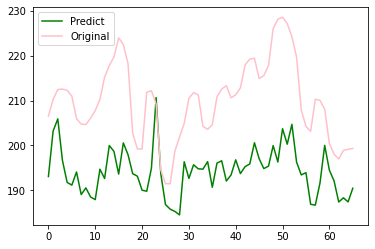

Running time: 55 seconds


In [2]:
#LSTM-SED
import tensorflow as tf
from tensorflow.python.keras.layers import merge
from tensorflow.python.keras.layers.merge import Multiply
from tensorflow.python.keras.layers.core import *
from tensorflow.python.keras.models import *

import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Input,Dense,Reshape,Dropout, Embedding, LSTM, Bidirectional,Permute
from tensorflow.python.keras.layers import RepeatVector, TimeDistributed
from tensorflow.python.keras.layers.recurrent import GRU
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat, read_csv
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sklearn.metrics as skm
import math
from math import sqrt
import time

# fix random seed for reproducibility
np.random.seed(7)

start = time.time()


#1. load dataset
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD_NFP.csv', engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
data = dataset.reshape(-1,6)


timestep = 6
dim = 6

#数据缩放 拆分输入X（7维）&输出Y（1维）
X = dataset[:,0:6]
scaler = MinMaxScaler(feature_range=(0, 1))
for i in range(dim):
    Xdata = X[:,i]
    Xdata = Xdata.reshape(-1,1)
    Xdata = scaler.fit_transform(Xdata)
    Xdata = Xdata.flatten()
    X[:,i] = Xdata
X_scaler = X.reshape(324,-1)
print(X_scaler.shape)

Y = dataset[:,0]
Y_scaler= (Y-np.min(Y))/(np.max(Y)-np.min(Y))
Y_scaler = Y_scaler.reshape(-1)
print(Y_scaler.shape)


#重构数据集
##timestep为时间步长
def create_X(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[i:(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)

def create_Y(seq, timestep):
    dataY = []
    for i in range(len(seq)-timestep):
        # Y向后移动一位取值
        dataY.append(seq[i+timestep])
    return np.array(dataY)



def get_lstm_model():
    K.clear_session() #清除之前的模型，省得压满内存
    inputs = Input(shape=(timestep, dim,))
    lstm_units1 = 60
    lstm_units2 = 12
    lstm_out1 = LSTM(lstm_units1, return_sequences=True)(inputs)
    lstm_out2 = LSTM(lstm_units2, return_sequences=True)(lstm_out1)
    lstm_out = Flatten()(lstm_out2)
    output = Dense(1, activation='relu')(lstm_out)
    model = Model(inputs=inputs, outputs=output)
    return model



#预测
pres=[]
# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.78)
test_size = len(dataset) - train_size
trainX, testX = X_scaler[0:train_size], X_scaler[train_size:len(dataset)]
trainY, testY = Y_scaler[0:train_size], Y_scaler[train_size:len(dataset)]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)
#print(trainX,trainX.shape)
#print(trainY,trainY.shape)
#print(testX,testX.shape)
#print(testY,testY.shape)

train_X=create_X(trainX,timestep)#(246,6)
#print(train_X,train_X.shape)
train_Y=create_Y(trainY,timestep)#(246,)
#print(train_Y,train_Y.shape)
test_X=create_X(testX,timestep)#(66,6,6)
#print(test_X,test_X.shape)
test_Y=create_Y(testY,timestep)#(66,)
#print(test_Y,test_Y.shape)

if __name__ == '__main__':
        
    model = get_lstm_model()
    optimizer = Adam(0.01)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    
    model.fit(train_X, train_Y, epochs=1000, batch_size=64)

    
    # 开始预测
    trainPredict = model.predict(train_X)
    testPredict = model.predict(test_X)


    # 逆缩放预测值
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD_NFP.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    #trainPredict = trainPredict*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori = trainY*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori=trainY_re.reshape((246,1))
    testPre = testPredict*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPre.reshape(-1)
    Y = dataset[:,0]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape(-1)

    

    # 计算误差
    #trainScore = math.sqrt(mean_squared_error(trainY_ori[:,0], trainPredict[:,0]))
    #print('Train Score: %.2f RMSE' % (trainScore))
    #testScore = math.sqrt(mean_squared_error(testY_ori[:,0], testPredict[:,0]))
    #print('Test Score: %.2f RMSE' % (testScore))


    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPre[i])
        error1.append(abs((testY_ori[i] - testPre[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPre[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPre[i]*testPre[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPre[i+1])/testY_ori[i])*((testY_ori[i+1] - testPre[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPre[i])/testY_ori[i])*((testY_ori[i+1] - testPre[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPre=testPre.reshape(-1)
    testPre=pd.DataFrame(testPre)
    testPre.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/lstmoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/lstmEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)
    
    plt.figure(facecolor='white')
    plt.plot(testPre,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPre)



end = time.time()
print('Running time: %d seconds'%(end - start))

(324, 6)
(324,)
原始训练集的长度： 252
原始测试集的长度： 72
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 6)]            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 6, 120)            32160     
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 12)             6384      
_________________________________________________________________
dropout (Dropout)            (None, 6, 12)             0         
_________________________________________________________________
flatten (Flatten)            (None, 72)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 73        
Total params: 38,617
Trainable params: 38,617
Non-trainable params: 0
______________

246/246 [==============================] - 0s 219us/sample - loss: 0.0032
Epoch 81/1000
246/246 [==============================] - 0s 207us/sample - loss: 0.0037
Epoch 82/1000
246/246 [==============================] - 0s 219us/sample - loss: 0.0037
Epoch 83/1000
246/246 [==============================] - 0s 268us/sample - loss: 0.0032
Epoch 84/1000
246/246 [==============================] - 0s 223us/sample - loss: 0.0030
Epoch 85/1000
246/246 [==============================] - 0s 223us/sample - loss: 0.0031
Epoch 86/1000
246/246 [==============================] - 0s 215us/sample - loss: 0.0031
Epoch 87/1000
246/246 [==============================] - 0s 207us/sample - loss: 0.0030
Epoch 88/1000
246/246 [==============================] - 0s 207us/sample - loss: 0.0028
Epoch 89/1000
246/246 [==============================] - 0s 207us/sample - loss: 0.0032
Epoch 90/1000
246/246 [==============================] - 0s 207us/sample - loss: 0.0031
Epoch 91/1000
246/246 [=======================

246/246 [==============================] - 0s 203us/sample - loss: 0.0022
Epoch 173/1000
246/246 [==============================] - 0s 207us/sample - loss: 0.0021
Epoch 174/1000
246/246 [==============================] - 0s 207us/sample - loss: 0.0020
Epoch 175/1000
246/246 [==============================] - 0s 203us/sample - loss: 0.0020
Epoch 176/1000
246/246 [==============================] - 0s 203us/sample - loss: 0.0019
Epoch 177/1000
246/246 [==============================] - 0s 207us/sample - loss: 0.0026
Epoch 178/1000
246/246 [==============================] - 0s 199us/sample - loss: 0.0021
Epoch 179/1000
246/246 [==============================] - 0s 207us/sample - loss: 0.0023
Epoch 180/1000
246/246 [==============================] - 0s 207us/sample - loss: 0.0024
Epoch 181/1000
246/246 [==============================] - 0s 199us/sample - loss: 0.0026
Epoch 182/1000
246/246 [==============================] - 0s 207us/sample - loss: 0.0028
Epoch 183/1000
246/246 [============

246/246 [==============================] - 0s 203us/sample - loss: 0.0019
Epoch 265/1000
246/246 [==============================] - 0s 223us/sample - loss: 0.0016
Epoch 266/1000
246/246 [==============================] - 0s 255us/sample - loss: 0.0020
Epoch 267/1000
246/246 [==============================] - 0s 215us/sample - loss: 0.0018
Epoch 268/1000
246/246 [==============================] - 0s 219us/sample - loss: 0.0019
Epoch 269/1000
246/246 [==============================] - 0s 219us/sample - loss: 0.0016
Epoch 270/1000
246/246 [==============================] - 0s 215us/sample - loss: 0.0017
Epoch 271/1000
246/246 [==============================] - 0s 207us/sample - loss: 0.0017
Epoch 272/1000
246/246 [==============================] - 0s 211us/sample - loss: 0.0016
Epoch 273/1000
246/246 [==============================] - 0s 215us/sample - loss: 0.0016
Epoch 274/1000
246/246 [==============================] - 0s 207us/sample - loss: 0.0015
Epoch 275/1000
246/246 [============

246/246 [==============================] - 0s 227us/sample - loss: 0.0014
Epoch 357/1000
246/246 [==============================] - 0s 235us/sample - loss: 0.0015
Epoch 358/1000
246/246 [==============================] - 0s 223us/sample - loss: 0.0018
Epoch 359/1000
246/246 [==============================] - 0s 231us/sample - loss: 0.0015
Epoch 360/1000
246/246 [==============================] - 0s 235us/sample - loss: 0.0015
Epoch 361/1000
246/246 [==============================] - 0s 247us/sample - loss: 0.0015
Epoch 362/1000
246/246 [==============================] - 0s 264us/sample - loss: 0.0020
Epoch 363/1000
246/246 [==============================] - 0s 272us/sample - loss: 0.0021
Epoch 364/1000
246/246 [==============================] - 0s 401us/sample - loss: 0.0016
Epoch 365/1000
246/246 [==============================] - 0s 373us/sample - loss: 0.0017
Epoch 366/1000
246/246 [==============================] - 0s 628us/sample - loss: 0.0014
Epoch 367/1000
246/246 [============

246/246 [==============================] - 0s 280us/sample - loss: 0.0015
Epoch 449/1000
246/246 [==============================] - 0s 418us/sample - loss: 0.0013
Epoch 450/1000
246/246 [==============================] - 0s 296us/sample - loss: 0.0013
Epoch 451/1000
246/246 [==============================] - 0s 280us/sample - loss: 0.0013
Epoch 452/1000
246/246 [==============================] - 0s 280us/sample - loss: 0.0015
Epoch 453/1000
246/246 [==============================] - 0s 369us/sample - loss: 0.0012
Epoch 454/1000
246/246 [==============================] - 0s 300us/sample - loss: 0.0013
Epoch 455/1000
246/246 [==============================] - 0s 243us/sample - loss: 0.0014
Epoch 456/1000
246/246 [==============================] - 0s 239us/sample - loss: 0.0014
Epoch 457/1000
246/246 [==============================] - 0s 259us/sample - loss: 0.0014
Epoch 458/1000
246/246 [==============================] - 0s 251us/sample - loss: 0.0014
Epoch 459/1000
246/246 [============

246/246 [==============================] - 0s 284us/sample - loss: 0.0011
Epoch 541/1000
246/246 [==============================] - 0s 219us/sample - loss: 0.0011
Epoch 542/1000
246/246 [==============================] - 0s 211us/sample - loss: 0.0011
Epoch 543/1000
246/246 [==============================] - 0s 223us/sample - loss: 0.0014
Epoch 544/1000
246/246 [==============================] - 0s 215us/sample - loss: 0.0011
Epoch 545/1000
246/246 [==============================] - 0s 215us/sample - loss: 0.0012
Epoch 546/1000
246/246 [==============================] - 0s 215us/sample - loss: 0.0013
Epoch 547/1000
246/246 [==============================] - 0s 223us/sample - loss: 0.0013
Epoch 548/1000
246/246 [==============================] - 0s 223us/sample - loss: 0.0013
Epoch 549/1000
246/246 [==============================] - 0s 223us/sample - loss: 0.0014
Epoch 550/1000
246/246 [==============================] - 0s 215us/sample - loss: 0.0013
Epoch 551/1000
246/246 [============

246/246 [==============================] - 0s 259us/sample - loss: 0.0014
Epoch 633/1000
246/246 [==============================] - 0s 239us/sample - loss: 0.0014
Epoch 634/1000
246/246 [==============================] - 0s 227us/sample - loss: 0.0011
Epoch 635/1000
246/246 [==============================] - 0s 227us/sample - loss: 0.0010
Epoch 636/1000
246/246 [==============================] - 0s 227us/sample - loss: 0.0010
Epoch 637/1000
246/246 [==============================] - 0s 219us/sample - loss: 0.0013
Epoch 638/1000
246/246 [==============================] - 0s 231us/sample - loss: 8.5995e-04
Epoch 639/1000
246/246 [==============================] - 0s 251us/sample - loss: 0.0012
Epoch 640/1000
246/246 [==============================] - 0s 227us/sample - loss: 0.0012
Epoch 641/1000
246/246 [==============================] - 0s 219us/sample - loss: 0.0013
Epoch 642/1000
246/246 [==============================] - 0s 259us/sample - loss: 0.0014
Epoch 643/1000
246/246 [========

Epoch 724/1000
246/246 [==============================] - 0s 227us/sample - loss: 0.0010
Epoch 725/1000
246/246 [==============================] - 0s 243us/sample - loss: 0.0012
Epoch 726/1000
246/246 [==============================] - 0s 215us/sample - loss: 0.0014
Epoch 727/1000
246/246 [==============================] - 0s 219us/sample - loss: 0.0013
Epoch 728/1000
246/246 [==============================] - 0s 223us/sample - loss: 0.0013
Epoch 729/1000
246/246 [==============================] - 0s 223us/sample - loss: 0.0014
Epoch 730/1000
246/246 [==============================] - 0s 328us/sample - loss: 0.0011
Epoch 731/1000
246/246 [==============================] - 0s 219us/sample - loss: 7.5600e-04
Epoch 732/1000
246/246 [==============================] - 0s 219us/sample - loss: 0.0013
Epoch 733/1000
246/246 [==============================] - 0s 219us/sample - loss: 0.0013
Epoch 734/1000
246/246 [==============================] - 0s 231us/sample - loss: 0.0012
Epoch 735/1000
24

246/246 [==============================] - 0s 227us/sample - loss: 0.0012
Epoch 816/1000
246/246 [==============================] - 0s 223us/sample - loss: 0.0013
Epoch 817/1000
246/246 [==============================] - 0s 219us/sample - loss: 0.0013
Epoch 818/1000
246/246 [==============================] - 0s 239us/sample - loss: 0.0010
Epoch 819/1000
246/246 [==============================] - 0s 231us/sample - loss: 0.0013
Epoch 820/1000
246/246 [==============================] - 0s 312us/sample - loss: 0.0011
Epoch 821/1000
246/246 [==============================] - 0s 255us/sample - loss: 9.9716e-04
Epoch 822/1000
246/246 [==============================] - 0s 219us/sample - loss: 0.0011
Epoch 823/1000
246/246 [==============================] - 0s 219us/sample - loss: 0.0012
Epoch 824/1000
246/246 [==============================] - 0s 219us/sample - loss: 0.0012
Epoch 825/1000
246/246 [==============================] - 0s 223us/sample - loss: 9.5659e-04
Epoch 826/1000
246/246 [====

246/246 [==============================] - 0s 243us/sample - loss: 0.0012
Epoch 907/1000
246/246 [==============================] - 0s 223us/sample - loss: 0.0011
Epoch 908/1000
246/246 [==============================] - 0s 223us/sample - loss: 0.0011
Epoch 909/1000
246/246 [==============================] - 0s 231us/sample - loss: 0.0012
Epoch 910/1000
246/246 [==============================] - 0s 223us/sample - loss: 0.0011
Epoch 911/1000
246/246 [==============================] - 0s 280us/sample - loss: 0.0015
Epoch 912/1000
246/246 [==============================] - 0s 341us/sample - loss: 0.0013
Epoch 913/1000
246/246 [==============================] - 0s 247us/sample - loss: 0.0015
Epoch 914/1000
246/246 [==============================] - 0s 227us/sample - loss: 0.0014
Epoch 915/1000
246/246 [==============================] - 0s 231us/sample - loss: 0.0015
Epoch 916/1000
246/246 [==============================] - 0s 247us/sample - loss: 0.0013
Epoch 917/1000
246/246 [============

246/246 [==============================] - 0s 276us/sample - loss: 0.0015
Epoch 998/1000
246/246 [==============================] - 0s 272us/sample - loss: 9.7560e-04
Epoch 999/1000
246/246 [==============================] - 0s 292us/sample - loss: 0.0010
Epoch 1000/1000
246/246 [==============================] - 0s 280us/sample - loss: 0.0010

MAE= 9.123882640491832
RMSE =  11.025315591286658
NMSE =  0.18512857446917508
MAPE= 0.04273191499426806
IA= 0.594693729046041
U1= 0.02675875094611937
U2= 0.93313562873907


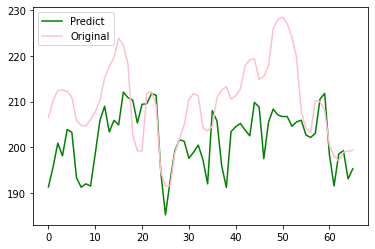

Running time: 70 seconds


In [3]:
#Bi-LSTM-SED
import tensorflow as tf
from tensorflow.python.keras.layers import merge
from tensorflow.python.keras.layers.merge import Multiply
from tensorflow.python.keras.layers.core import *
from tensorflow.python.keras.models import *

import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Input,Dense,Reshape,Dropout, Embedding, LSTM, Bidirectional,Permute
from tensorflow.python.keras.layers import RepeatVector, TimeDistributed
from tensorflow.python.keras.layers.recurrent import GRU
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat, read_csv
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sklearn.metrics as skm
import math
from math import sqrt
import time

# fix random seed for reproducibility
np.random.seed(7)

start = time.time()


#1. load dataset
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD_NFP.csv', engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
data = dataset.reshape(-1,6)


timestep = 6
dim = 6

#数据缩放 拆分输入X（7维）&输出Y（1维）
X = dataset[:,0:6]
scaler = MinMaxScaler(feature_range=(0, 1))
for i in range(dim):
    Xdata = X[:,i]
    Xdata = Xdata.reshape(-1,1)
    Xdata = scaler.fit_transform(Xdata)
    Xdata = Xdata.flatten()
    X[:,i] = Xdata
X_scaler = X.reshape(324,-1)
print(X_scaler.shape)

Y = dataset[:,0]
Y_scaler= (Y-np.min(Y))/(np.max(Y)-np.min(Y))
Y_scaler = Y_scaler.reshape(-1)
print(Y_scaler.shape)


#重构数据集
##timestep为时间步长
def create_X(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[i:(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)

def create_Y(seq, timestep):
    dataY = []
    for i in range(len(seq)-timestep):
        # Y向后移动一位取值
        dataY.append(seq[i+timestep])
    return np.array(dataY)



def get_bilstm_model():
    K.clear_session() #清除之前的模型，省得压满内存
    inputs = Input(shape=(timestep, dim,))
    lstm_units1 = 60
    lstm_units2 = 12
    bilstm_out1 = Bidirectional(LSTM(lstm_units1,return_sequences=True),merge_mode='concat')(inputs)
    bilstm_out2 = LSTM(lstm_units2, return_sequences=True)(bilstm_out1)
    dropout_out = Dropout(0.5)(bilstm_out2)
    bilstm_out = Flatten()(dropout_out)
    output = Dense(1, activation='relu')(bilstm_out)
    model = Model(inputs=inputs, outputs=output)
    return model



#预测
pres=[]
# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.78)
test_size = len(dataset) - train_size
trainX, testX = X_scaler[0:train_size], X_scaler[train_size:len(dataset)]
trainY, testY = Y_scaler[0:train_size], Y_scaler[train_size:len(dataset)]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)
#print(trainX,trainX.shape)
#print(trainY,trainY.shape)
#print(testX,testX.shape)
#print(testY,testY.shape)

train_X=create_X(trainX,timestep)#(246,6)
#print(train_X,train_X.shape)
train_Y=create_Y(trainY,timestep)#(246,)
#print(train_Y,train_Y.shape)
test_X=create_X(testX,timestep)#(66,6,6)
#print(test_X,test_X.shape)
test_Y=create_Y(testY,timestep)#(66,)
#print(test_Y,test_Y.shape)

if __name__ == '__main__':
        
    model = get_bilstm_model()
    optimizer = Adam(0.01)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    
    model.fit(train_X, train_Y, epochs=1000, batch_size=64)

    # 开始预测
    trainPredict = model.predict(train_X)
    testPredict = model.predict(test_X)


    # 逆缩放预测值
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD_NFP.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    #trainPredict = trainPredict*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori = trainY*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori=trainY_re.reshape((246,1))
    testPre = testPredict*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPre.reshape(-1)
    Y = dataset[:,0]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape(-1)

    

    # 计算误差
    #trainScore = math.sqrt(mean_squared_error(trainY_ori[:,0], trainPredict[:,0]))
    #print('Train Score: %.2f RMSE' % (trainScore))
    #testScore = math.sqrt(mean_squared_error(testY_ori[:,0], testPredict[:,0]))
    #print('Test Score: %.2f RMSE' % (testScore))


    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPre[i])
        error1.append(abs((testY_ori[i] - testPre[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPre[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPre[i]*testPre[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPre[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPre[i+1])/testY_ori[i])*((testY_ori[i+1] - testPre[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPre[i])/testY_ori[i])*((testY_ori[i+1] - testPre[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPre=testPre.reshape(-1)
    testPre=pd.DataFrame(testPre)
    testPre.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/lstmoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/lstmEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)
    
    plt.figure(facecolor='white')
    plt.plot(testPre,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPre)



end = time.time()
print('Running time: %d seconds'%(end - start))